# Librerías

In [1]:
# Importamos las librerías
import os, logging

from matplotlib.pyplot import (
    matshow,
    colorbar,
    xlabel,
    ylabel,
    plot,
    legend,
    grid,
)

from niftypet import nipet

import matplotlib.pyplot as plt
import time as tm

from os import path
import time as tm
import functools
from scipy.ndimage.filters import gaussian_filter
import numpy as np
from tqdm.auto import trange

logging.basicConfig(level=logging.WARN)
mMRpars = nipet.get_mmrparams()

# Medidas para calcular las diferencias
from skimage.metrics import (
    mean_squared_error,
    peak_signal_noise_ratio,
    structural_similarity,
)

# Guardar los datos
import pickle

/tmp/ipykernel_2959/952055420.py:22: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


## Funciones adicionales

In [2]:
def div_nzer(x, y):
    return np.divide(x, y, out=np.zeros_like(y), where=y != 0)


def recortar(x):
    return x[100:-120, 110:-110]

# OSEM

In [3]:
# Definimos la ruta a los archivos
folderin = "/mnt/test1dev/TIC/00Datos/amyloidPET_FBP_TP0"

# Leemos los archivos
datain = nipet.classify_input(folderin, mMRpars)

# Definimos la ruta de salida
opth = os.path.join(datain["corepath"], "output")

datain

# Obtenemos los mapas de atenuación de hardware (cama y bobina de cabeza y cuello)
muhdct = nipet.hdw_mumap(datain, [1, 2, 4], mMRpars, outpath=opth, use_stored=True)

# Obtenemos el mapa de atenuación humano basado en RM
muodct = nipet.obj_mumap(datain, mMRpars, outpath=opth, store=True)

hst = nipet.mmrhist(datain, mMRpars)

Chris Rorden's dcm2niiX version v1.0.20220505  GCC9.4.0 x86-64 (64-bit Linux)
Found 192 DICOM file(s)
Convert 192 DICOM as /mnt/test1dev/TIC/00Datos/amyloidPET_FBP_TP0/output/mumap-obj/converted-from-object-DICOM_2024-7-24_20h22_e2 (192x192x192x1)
Conversion required 18.406109 seconds (0.239231 for core code).
i> the list-mode file: /mnt/test1dev/TIC/00Datos/amyloidPET_FBP_TP0/LM/17598013_1946_20150604155500.000000.bf
i> number of elements in the list mode file: 2392502563
i> the first time tag is:       0 at positon 1.
i> the last time tag is:        3600022 at positon 2392502557.
i> using time offset:           0
i> number of report itags is:   3601
i> # chunks of data (initial):  201

i> # elechnk:  12582912

i> setting up data chunks:
i> break time tag [191] is:     3600023ms at position 2392502563. 
i> frame start time: 0
i> frame stop  time: 3601
i> using CUDA device #0

i> setting up CUDA pseudorandom number generator... DONE.

i> creating 32 CUDA streams... DONE.

i> reading th

In [6]:
# Cargar las variables desde el archivo pickle
with open(
    "datos_resultados/resultados_metrica_completa/datos_objetivo.pickle", "rb"
) as file:
    datos_objetivo = pickle.load(file)

In [7]:
datos_objetivo.shape

(127, 344, 344)

In [8]:
def normalizar_imagen(imagen):
    return (imagen - np.min(imagen)) / (
        np.max(imagen) - np.min(imagen) if np.max(imagen) - np.min(imagen) != 0 else 1
    )

In [9]:
def calcular_parametro_parada_comparacion(
    dato_actual, datos_referencia, datos_iteraciones, modo="full", criterio="SSIM"
):

    dato_anterior = datos_referencia
    dato_actual = dato_actual

    # normalizamos los datos
    dato_anterior = normalizar_imagen(dato_anterior)
    dato_actual = normalizar_imagen(dato_actual)

    if modo == "full":
        dimensiones_imagen = dato_anterior.shape
        dimension_1 = dimensiones_imagen[0]
        dimension_2 = dimensiones_imagen[1]
        dimension_3 = dimensiones_imagen[2]

        # Obtenemos 3 muestras igualmente espaciadas en cada dimensión
        muestras_dimension_1 = [
            dimension_1 // 4,
            2 * dimension_1 // 4,
            3 * dimension_1 // 4,
        ]
        muestras_dimension_2 = [
            dimension_2 // 4,
            2 * dimension_2 // 4,
            3 * dimension_2 // 4,
        ]
        muestras_dimension_3 = [
            dimension_3 // 4,
            2 * dimension_3 // 4,
            3 * dimension_3 // 4,
        ]

        # Calculamos los criterios en cada dimensión
        # MSE
        criterio_MSE_dimension_1 = []

        for i in muestras_dimension_1:
            criterio_MSE_dimension_1.append(
                mean_squared_error(dato_anterior[i, :, :], dato_actual[i, :, :])
            )

        criterio_MSE_1 = np.mean(criterio_MSE_dimension_1)

        criterio_MSE_dimension_2 = []
        for i in muestras_dimension_2:
            criterio_MSE_dimension_2.append(
                mean_squared_error(dato_anterior[:, i, :], dato_actual[:, i, :])
            )

        criterio_MSE_2 = np.mean(criterio_MSE_dimension_2)

        criterio_MSE_dimension_3 = []
        for i in muestras_dimension_3:
            criterio_MSE_dimension_3.append(
                mean_squared_error(dato_anterior[:, :, i], dato_actual[:, :, i])
            )

        criterio_MSE_3 = np.mean(criterio_MSE_dimension_3)

        criterio_MSE = np.mean([criterio_MSE_1, criterio_MSE_2, criterio_MSE_3])

        print(criterio_MSE)

        # PSNR
        criterio_PSNR_dimension_1 = []
        for i in muestras_dimension_1:
            criterio_PSNR_dimension_1.append(
                peak_signal_noise_ratio(
                    dato_anterior[i, :, :], dato_actual[i, :, :], data_range=1
                )
            )

        criterio_PSNR_1 = np.mean(criterio_PSNR_dimension_1)

        criterio_PSNR_dimension_2 = []

        for i in muestras_dimension_2:
            criterio_PSNR_dimension_2.append(
                peak_signal_noise_ratio(
                    dato_anterior[:, i, :], dato_actual[:, i, :], data_range=1
                )
            )

        criterio_PSNR_2 = np.mean(criterio_PSNR_dimension_2)

        criterio_PSNR_dimension_3 = []

        for i in muestras_dimension_3:
            criterio_PSNR_dimension_3.append(
                peak_signal_noise_ratio(
                    dato_anterior[:, :, i], dato_actual[:, :, i], data_range=1
                )
            )

        criterio_PSNR_3 = np.mean(criterio_PSNR_dimension_3)

        criterio_PSNR = np.mean([criterio_PSNR_1, criterio_PSNR_2, criterio_PSNR_3])

        # SSIM

        criterio_SSIM_dimension_1 = []

        for i in muestras_dimension_1:
            criterio_SSIM_dimension_1.append(
                structural_similarity(
                    dato_anterior[i, :, :], dato_actual[i, :, :], data_range=1
                )
            )

        print(criterio_SSIM_dimension_1)

        criterio_SSIM_1 = np.mean(criterio_SSIM_dimension_1)

        criterio_SSIM_dimension_2 = []

        for i in muestras_dimension_2:
            criterio_SSIM_dimension_2.append(
                structural_similarity(
                    dato_anterior[:, i, :], dato_actual[:, i, :], data_range=1
                )
            )

        criterio_SSIM_2 = np.mean(criterio_SSIM_dimension_2)

        criterio_SSIM_dimension_3 = []

        for i in muestras_dimension_3:
            criterio_SSIM_dimension_3.append(
                structural_similarity(
                    dato_anterior[:, :, i], dato_actual[:, :, i], data_range=1
                )
            )

        criterio_SSIM_3 = np.mean(criterio_SSIM_dimension_3)

        criterio_SSIM = np.mean([criterio_SSIM_1, criterio_SSIM_2, criterio_SSIM_3])

    datos_criterios = {
        "MSE": criterio_MSE,
        "PSNR": criterio_PSNR,
        "SSIM": criterio_SSIM,
    }

    diferenica_MSE = np.abs(datos_iteraciones[-1]["MSE"] - criterio_MSE)
    diferenica_PSNR = np.abs(datos_iteraciones[-1]["PSNR"] - criterio_PSNR)
    diferenica_SSIM = np.abs(1 - criterio_SSIM)

    valor_criterio_evaluacion = 0

    if criterio == "MSE":
        valor_criterio_evaluacion = diferenica_MSE
    elif criterio == "PSNR":
        valor_criterio_evaluacion = diferenica_PSNR
    elif criterio == "SSIM":
        valor_criterio_evaluacion = diferenica_SSIM

    return datos_criterios, valor_criterio_evaluacion

In [13]:
reconstrucciones_osem = [np.ones_like(datos_objetivo)]

datos_iteracion_osem = [
    {
        "iteracion": -1,
        "tiempo_iteracion": 0,
        "MSE": 0,
        "PSNR": 0,
        "SSIM": 0,
    }
]

iteracion_osem = 1
iteracion = 1
tolerancia = 0.005
citerio_parada_osem = 1

while (citerio_parada_osem > tolerancia and iteracion_osem <= 10):

    # measure time
    t0 = tm.time()

    recon = nipet.mmrchain(
        datain,
        mMRpars,
        frames=["timings", [0, 3600]],
        mu_h=muhdct,
        mu_o=muodct,
        itr=iteracion_osem,
        fwhm=0.0,
        outpath=opth,
        fcomment="niftypet-recon",
        store_img=True,
    )

    tiempo_final = tm.time() - t0

    reconstrucciones_osem.append(recon)

    datos_criterios_osem, citerio_parada_osem = calcular_parametro_parada_comparacion(
        recon['im'], datos_objetivo, datos_iteracion_osem
    )

    datos_criterios_osem["iteracion"] = iteracion_osem
    datos_criterios_osem["tiempo_iteracion"] = tiempo_final

    print(datos_criterios_osem)

    datos_iteracion_osem.append(datos_criterios_osem)

    iteracion_osem += 1

i> the list-mode file: /mnt/test1dev/TIC/00Datos/amyloidPET_FBP_TP0/LM/17598013_1946_20150604155500.000000.bf
i> number of elements in the list mode file: 2392502563
i> the first time tag is:       0 at positon 1.
i> the last time tag is:        3600022 at positon 2392502557.
i> using time offset:           0
i> number of report itags is:   3601
i> # chunks of data (initial):  201

i> # elechnk:  12582912

i> setting up data chunks:
i> break time tag [191] is:     3600023ms at position 2392502563. 
i> frame start time: 0
i> frame stop  time: 3600
i> using CUDA device #0

i> setting up CUDA pseudorandom number generator... DONE.

i> creating 32 CUDA streams... DONE.

i> reading the first chunks of LM data from:
   /mnt/test1dev/TIC/00Datos/amyloidPET_FBP_TP0/LM/17598013_1946_20150604155500.000000.bf  DONE.

+> histogramming the LM data:
   +> stream[2]:   191 chunks of data are DONE.   
ic> total prompt single slice rebinned sinogram:  P = 1570702342

ic> total prompt and delayeds sinog

0.0022195333485687248
[0.9861284184478724, 0.9604055661200602, 0.9502073937152081]
{'MSE': 0.0022195333485687248, 'PSNR': 46.54298670362609, 'SSIM': 0.9596441809462473, 'iteracion': 1, 'tiempo_iteracion': 21.64486050605774}
i> the list-mode file: /mnt/test1dev/TIC/00Datos/amyloidPET_FBP_TP0/LM/17598013_1946_20150604155500.000000.bf
i> number of elements in the list mode file: 2392502563
i> the first time tag is:       0 at positon 1.
i> the last time tag is:        3600022 at positon 2392502557.
i> using time offset:           0
i> number of report itags is:   3601
i> # chunks of data (initial):  201

i> # elechnk:  12582912

i> setting up data chunks:
i> break time tag [191] is:     3600023ms at position 2392502563. 
i> frame start time: 0
i> frame stop  time: 3600
i> using CUDA device #0

i> setting up CUDA pseudorandom number generator... DONE.

i> creating 32 CUDA streams... DONE.

i> reading the first chunks of LM data from:
   /mnt/test1dev/TIC/00Datos/amyloidPET_FBP_TP0/LM/17598

0.0006502858110610232
[0.999212246418066, 0.9846215247800089, 0.9805241474697011]
{'MSE': 0.0006502858110610232, 'PSNR': 54.29759535721218, 'SSIM': 0.9831770171721942, 'iteracion': 2, 'tiempo_iteracion': 48.1722629070282}
i> the list-mode file: /mnt/test1dev/TIC/00Datos/amyloidPET_FBP_TP0/LM/17598013_1946_20150604155500.000000.bf
i> number of elements in the list mode file: 2392502563
i> the first time tag is:       0 at positon 1.
i> the last time tag is:        3600022 at positon 2392502557.
i> using time offset:           0
i> number of report itags is:   3601
i> # chunks of data (initial):  201

i> # elechnk:  12582912

i> setting up data chunks:
i> break time tag [191] is:     3600023ms at position 2392502563. 
i> frame start time: 0
i> frame stop  time: 3600
i> using CUDA device #0

i> setting up CUDA pseudorandom number generator... DONE.

i> creating 32 CUDA streams... DONE.

i> reading the first chunks of LM data from:
   /mnt/test1dev/TIC/00Datos/amyloidPET_FBP_TP0/LM/1759801

0.00023687977150462785
[0.9996265522288632, 0.9924722087543546, 0.9900486150705022]
{'MSE': 0.00023687977150462785, 'PSNR': 58.75481099874372, 'SSIM': 0.9913032202502805, 'iteracion': 3, 'tiempo_iteracion': 75.12100076675415}
i> the list-mode file: /mnt/test1dev/TIC/00Datos/amyloidPET_FBP_TP0/LM/17598013_1946_20150604155500.000000.bf
i> number of elements in the list mode file: 2392502563
i> the first time tag is:       0 at positon 1.
i> the last time tag is:        3600022 at positon 2392502557.
i> using time offset:           0
i> number of report itags is:   3601
i> # chunks of data (initial):  201

i> # elechnk:  12582912

i> setting up data chunks:
i> break time tag [191] is:     3600023ms at position 2392502563. 
i> frame start time: 0
i> frame stop  time: 3600
i> using CUDA device #0

i> setting up CUDA pseudorandom number generator... DONE.

i> creating 32 CUDA streams... DONE.

i> reading the first chunks of LM data from:
   /mnt/test1dev/TIC/00Datos/amyloidPET_FBP_TP0/LM/175

0.00011365551781697217
[0.9996865420890811, 0.9956343609845286, 0.9942160074649532]
{'MSE': 0.00011365551781697217, 'PSNR': 61.18709929319717, 'SSIM': 0.9948547343507314, 'iteracion': 4, 'tiempo_iteracion': 101.0853762626648}
i> the list-mode file: /mnt/test1dev/TIC/00Datos/amyloidPET_FBP_TP0/LM/17598013_1946_20150604155500.000000.bf
i> number of elements in the list mode file: 2392502563
i> the first time tag is:       0 at positon 1.
i> the last time tag is:        3600022 at positon 2392502557.
i> using time offset:           0
i> number of report itags is:   3601
i> # chunks of data (initial):  201

i> # elechnk:  12582912

i> setting up data chunks:
i> break time tag [191] is:     3600023ms at position 2392502563. 
i> frame start time: 0
i> frame stop  time: 3600
i> using CUDA device #0

i> setting up CUDA pseudorandom number generator... DONE.

i> creating 32 CUDA streams... DONE.

i> reading the first chunks of LM data from:
   /mnt/test1dev/TIC/00Datos/amyloidPET_FBP_TP0/LM/175

In [19]:
len(reconstrucciones_osem)

6

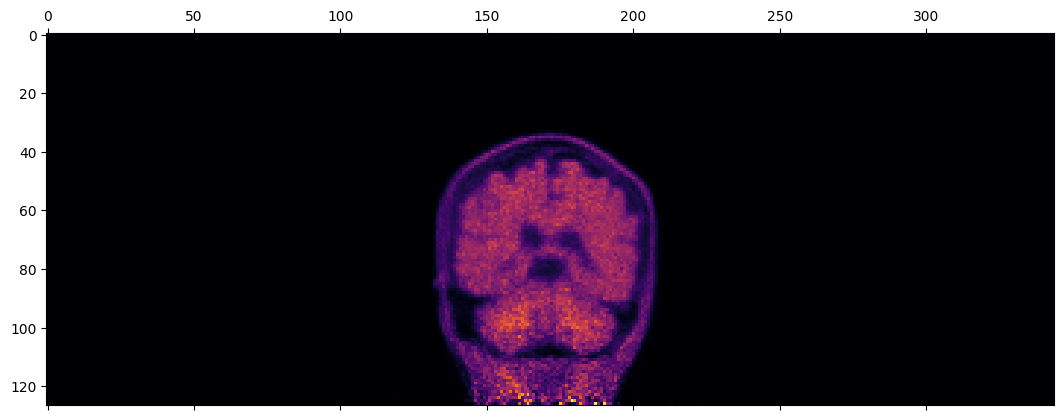

In [18]:
matshow(reconstrucciones_osem[-1]['im'][:, 175, :],cmap='inferno')

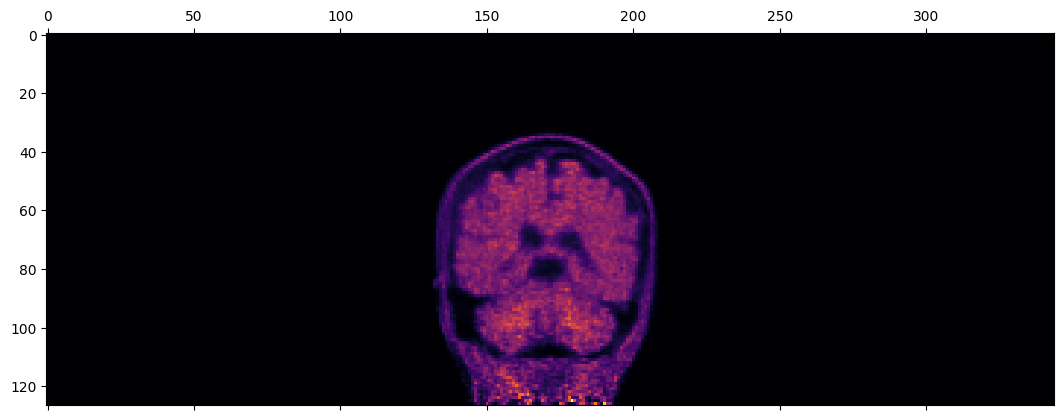

In [11]:
matshow(datos_objetivo[:, 175, :],cmap='inferno')

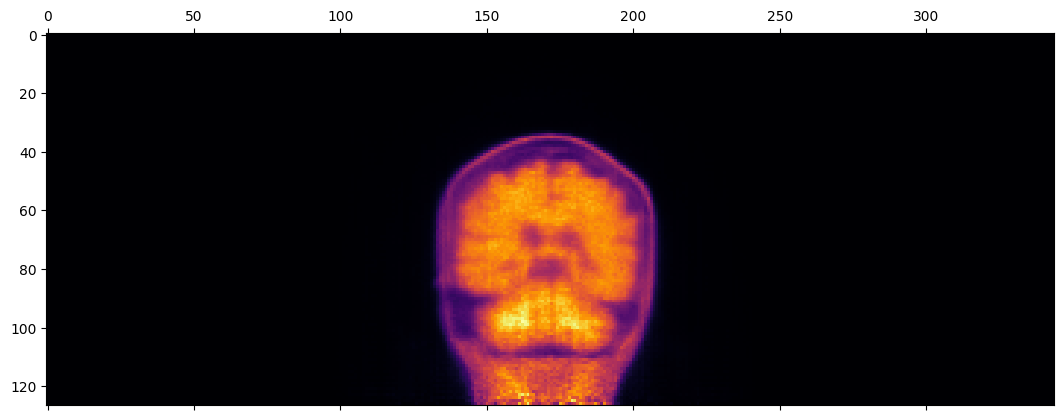

In [12]:
matshow(reconstrucciones_osem[1]['im'][:, 175, :],cmap='inferno')

In [16]:
reconstrucciones_osem_datos = [x['im'] for x in reconstrucciones_osem[1:]]

In [17]:
# guardamos los datos obtenidos de las reconstrucciones: recon_mlem
with open('datos_resultados/resultados_metrica_completa/recon_osem_crit0-005.pickle', 'wb') as handle:
    pickle.dump(reconstrucciones_osem_datos, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Guardamos los datos de los criterios de parada: datos_criterios_parada
with open('datos_resultados/resultados_metrica_completa/datos_iteraciones_osem_crit0-005.pickle', 'wb') as handle:
    pickle.dump(datos_iteracion_osem, handle, protocol=pickle.HIGHEST_PROTOCOL)